## 2D Inverse Terzaghi Problem (PINN)

Here, we attempt to invert *two* parameters from the 2D Terzaghi PDE by using the physics to predict the unknown parameters from exact solution data. The real parameter values are $c_{x} = 0.6$ and $c_{y} = 1.0$ respectively

In [1]:
import os
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt

from sciann.utils.math import sign, abs, sigmoid, tanh, diff

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)] 



In [2]:
t_min, t_max = 0, 1
x_min, x_max = 0, 4
y_min, y_max = 0, 4

xs = np.linspace(x_min, x_max, 50)
ys = np.linspace(y_min, y_max, 50)
ts = np.linspace(t_min, t_max, 1000)

### Parameter Inversion

In [3]:
# Load exact solution file
save_directory = r'C:\Users\Umar\OneDrive\UROP_PINNs\Terzaghi\Forward\Data'

U_mesh = np.load(os.path.join(save_directory, f'2D_data_50.npy'))

# Use same format
U_mesh = U_mesh.transpose(1, 0, 2) 

In [4]:
def PrepareData(num_data=50000, random=True):
    # Flattening the mesh grid
    X, Y, T = np.meshgrid(xs, ys, ts)
    X_flat = X.flatten()[:, None]
    Y_flat = Y.flatten()[:, None]
    T_flat = T.flatten()[:, None]
    
    # Calculating U_mesh
    U_mesh_flat = U_mesh.flatten()[:, None]
    
    # Pick random data
    if random:
        idx = np.random.choice(X_flat.shape[0], num_data, replace=False)
    else:
        idx = np.arange(0, X_flat.shape[0])
    
    x_train = X_flat[idx]
    y_train = Y_flat[idx]
    t_train = T_flat[idx]
    u_train = U_mesh_flat[idx]
    
    return (x_train, y_train, t_train, u_train)

x_train, y_train, t_train, u_train = PrepareData(50000, random=True)

In [5]:
# Define new variables and functionals
sn.reset_session()
sn.set_random_seed(1234)

# Define independent variables
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

# Define solution variable
U = sn.Functional("U", [x, y, t], 8*[20], 'tanh')

# Define parameters to be inverted (Double initial value)
cx_inv = sn.Parameter(2.0, non_neg=True, inputs=[x, y, t], name="cx_inv") # 0.6
cz_inv = sn.Parameter(2.0, non_neg=True, inputs=[x, y, t], name="cz_inv") # 1.0
#cv_inv = sn.Parameter(2.0, non_neg=True, inputs=[x, y, t], name="cv_inv")

# Define PDE (physics constraint)
U_t = diff(U, t)
U_x = diff(U, x)
U_y = diff(U, y)
U_xx = diff(U_x, x)
U_yy = diff(U_y, y)

PDE = cx_inv*U_xx + cz_inv*U_yy - U_t
#PDE = cv_inv*(U_xx + U_yy) - U_t

# Define targets for MSE loss function
data_target = sn.Data(U)
pde_constraint = sn.PDE(PDE)

# Collect all targets
targets = [data_target, pde_constraint]

In [8]:
epochs = 1000
batch_size = 500

model_inv = sn.SciModel(
    inputs=[x, y, t],
    targets=targets,
    loss_func="mse"
)

input_data = [x_train, y_train, t_train]
target_data = [u_train, 'zeros']

# Prepare the training input and target data
H_new = model_inv.train(
    input_data,
    target_data,
    epochs=epochs,
    batch_size=batch_size,
    stop_loss_value=1e-36,
    stop_after=None,
    verbose=2,
    log_parameters={'parameters': [cx_inv, cz_inv], 'freq': 1}
)
model_inv.save_weights('Inverse2DWeights.hdf5')


Total samples: 50000 
Batch size: 500 
Total batches: 100 

Epoch 1/1000
100/100 - 4s - loss: 0.0030 - U_loss: 0.0017 - sub_loss: 0.0014 - lr: 0.0010 - time: 4.0405 - cx_inv: 0.6971 - cz_inv: 1.0973 - 4s/epoch - 40ms/step
Epoch 2/1000
100/100 - 2s - loss: 6.1110e-04 - U_loss: 4.8345e-04 - sub_loss: 1.2766e-04 - lr: 0.0010 - time: 1.8915 - cx_inv: 0.6967 - cz_inv: 1.0965 - 2s/epoch - 19ms/step
Epoch 3/1000
100/100 - 2s - loss: 8.6521e-04 - U_loss: 6.6573e-04 - sub_loss: 1.9948e-04 - lr: 0.0010 - time: 1.8622 - cx_inv: 0.6970 - cz_inv: 1.0970 - 2s/epoch - 19ms/step
Epoch 4/1000



KeyboardInterrupt



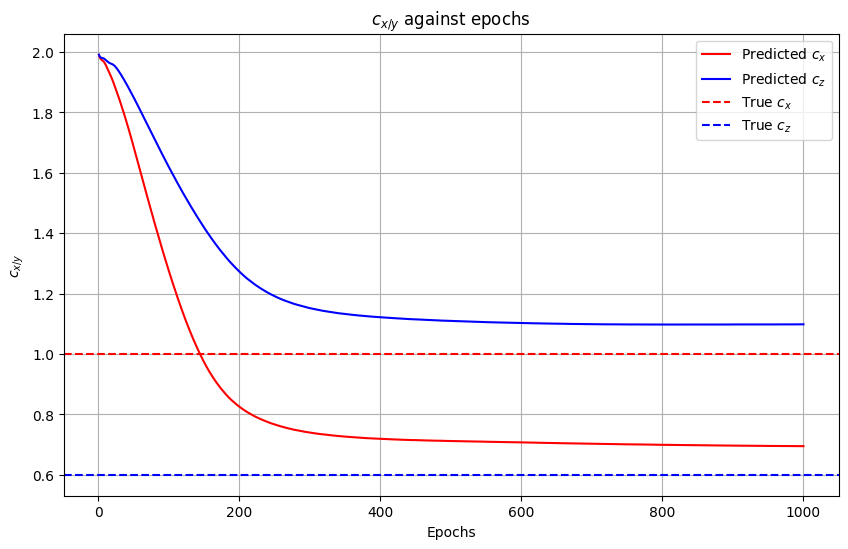

In [7]:
# Ensure 'parameter' contains the history of 'c_v' values
single = False

if single:
    cv_values = H_new.history['cv_inv']
    epochs = range(1, len(cv_values) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, cv_values, 'r-', label='Predicted $c_{v}$')
    plt.axhline(y=1.0, color='b', linestyle='--', label='True $c_{z}$')
    plt.xlabel('Epochs')
    plt.ylabel('$c_{X}$')
    plt.title('$c_{v}$ against epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig("InvertedCxCz_2D.png",dpi=600)
    plt.show()
    
else:
    cx_values = H_new.history['cx_inv']
    cz_values = H_new.history['cz_inv']
    epochs = range(1, len(cx_values) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, cx_values, 'r-', label='Predicted $c_{x}$')
    plt.plot(epochs, cz_values, 'b-', label='Predicted $c_{z}$')
    plt.axhline(y=1.0, color='r', linestyle='--', label='True $c_{x}$')
    plt.axhline(y=0.6, color='b', linestyle='--', label='True $c_{z}$')
    plt.xlabel('Epochs')
    plt.ylabel('$c_{x/y}$')
    plt.title('$c_{x/y}$ against epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig("InvertedCxCz_2D.png",dpi=600)
    plt.show()